In [1]:
import numpy as np
import emoji
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kl_div
from nltk.sentiment import SentimentIntensityAnalyzer
from data import source_wsl, output
from util import text, null
from util import Pipeline
from concurrent.futures import ProcessPoolExecutor


sia = SentimentIntensityAnalyzer()

def token_to_sentiment(row):
    text_ = " ".join(row)
    return pd.Series(sia.polarity_scores(text_))


In [2]:
data = pd.read_csv(source_wsl)
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
text_preprocess = {
	'replace emoji': [text.replace_emoji, null],
	'to lower': [str.lower, null],
	'remove punctuation': [(text.remove_pattern, text.PATTERN['punc']), null],  # ATTENTION: it will remove @ #
	'remove _': [(text.remove_pattern, r'_'), null],
	'tokenize': [nltk.tokenize.word_tokenize],
	'remove stopwords': [(text.remove_stopwords, text.STOP_WORDS + ['amp'])],
}  # input original text

pipelines = Pipeline.from_config(text_preprocess)

In [4]:
def process(tweets: pd.Series, pipeline):
	return pd.Series([pipeline(tweet) for tweet in tweets.to_numpy()])
		
pool = ProcessPoolExecutor()		
tweets = data['tweet']
futures = [pool.submit(process, tweets, pipeline) for pipeline in pipelines]
processed_texts = [pd.Series(future.result()) for future in futures]
# processed_texts = [future.result() for future in futures]
pool.shutdown()

In [5]:
processed_texts[0]

0        [rt, mayasolovely, woman, complain, cleaning, ...
1        [rt, mleew17, boy, dats, coldtyga, dwn, cuffin...
2        [rt, urkindofbrand, dawg, rt, 80sbaby4life, fu...
3                      [rt, cganderson, vivabased, tranny]
4        [rt, shenikaroberts, shit, hear, faker, bitch,...
                               ...                        
24778    [yous, muthafin, lie, lifeasking, 20pearls, co...
24779    [youve, broke, wrong, heart, baby, drove, redn...
24780         [young, buck, wan, eat, nigguh, fuckin, dis]
24781                  [youu, wild, bitches, tellin, lies]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

In [6]:
sentiment_scores = [texts.apply(token_to_sentiment) for texts in processed_texts]

In [7]:
sentiment_scores[0]

,neg,neu,pos,compound
0,0.294,0.706,0.000,-0.3612
1,0.000,1.000,0.000,0.0000
2,0.731,0.269,0.000,-0.9460
3,0.000,1.000,0.000,0.0000
4,0.597,0.403,0.000,-0.8126
...,...,...,...,...
24778,0.000,1.000,0.000,0.0000
24779,0.624,0.376,0.000,-0.8074
24780,0.000,1.000,0.000,0.0000
24781,0.691,0.309,0.000,-0.7717


In [8]:
polar = data['class'].map({2: -1, 1: -1, 0: 1})
polar

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
24778   -1
24779   -1
24780   -1
24781   -1
24782   -1
Name: class, Length: 24783, dtype: int64

In [9]:
kl_div(polar+2, sentiment_scores[0]['compound']+2).mean(), kl_div(polar+2, sentiment_scores[1]['compound']+2).mean()

(0.21281143771118818, 0.21281735093024134)

In [10]:
kl = [kl_div(polar+2, sentiment_score['compound']+2).mean() for sentiment_score in sentiment_scores]
kl

[0.21281143771118818,
 0.21281735093024134,
 0.22390674566936825,
 0.2239126588884214,
 0.21308503372357798,
 0.21308823707238428,
 0.22405770682630213,
 0.22406091017510846,
 0.2136011565932703,
 0.21360706981232344,
 0.2238105382100871,
 0.22381645142914028,
 0.21387695447961275,
 0.21388015782841904,
 0.22396604967798,
 0.22396925302678633]

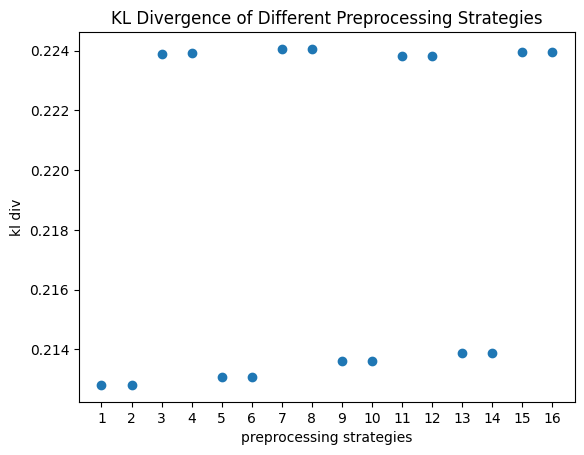

In [11]:
title = "KL Divergence of Different Preprocessing Strategies"
plt.title(title)
plt.ylabel("kl div")
plt.xlabel("preprocessing strategies")
plt.xticks(ticks=range(len(kl)), labels=range(1, 1+len(kl)))
plt.scatter(range(len(kl)), kl)
plt.savefig(output + f'/img/{title}.svg')

# 结论

使用全策略
（要删除标点，但标点在该场景下的确携带丰富信息--单独抽取特征）
（要替换emoji，emoji对于kl散度有一定的提升）